In [2]:
import klayout.db as db
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon

In [39]:
MASK_LAYER = 1
MASK_DATATYPE = 0
pixel_size_nm = 1.0  # 1px = 1nm
output_filename = "mask_pattern.jpg" #save file

#gds with klayout api
layout = db.Layout()
layout.read("C:/Users/USER/Documents/Phd/Test_Patterns-20260102T051200Z-3-001/Test_Patterns/pattern_3.gds")
top_cell = layout.top_cell()
print("Top cell name: ",top_cell.name)

Top cell name:  top


In [40]:
#Database unit check
dbu = layout.dbu
print("Database Unit: ",dbu," um") #If dbu=0.001, then an int value of 1000 = 1um, int value of 1=1nm

Database Unit:  0.001  um


In [41]:
#extract polygons
layer_info = db.LayerInfo(MASK_LAYER, MASK_DATATYPE)
layer_id = layout.layer(layer_info)

#Recursive region containing all polygons
region = db.Region(top_cell.begin_shapes_rec(layer_id))
region.merge() #mergees overlapping shapes

(0,0;0,50;250,50;250,0);(0,100;0,250;50,250;50,150;150,150;150,100);(350,0;350,100;200,100;200,250;250,250;250,150;400,150;400,0);(450,0;450,200;350,200;350,250;500,250;500,0)

In [42]:
#boundingbox
bbox = region.bbox()
width_dbu = bbox.width()
height_dbu = bbox.height()

#Size in pixels
#Eg: 703*(0.001*1000)/1
img_width = int(width_dbu * (dbu * 1000) / pixel_size_nm)
img_height = int(height_dbu * (dbu * 1000) / pixel_size_nm)

print("Image Size:",img_width,"x",img_height,"pixels")

Image Size: 500 x 250 pixels


In [43]:
#rasterize
raw_mask = np.zeros((img_height, img_width), dtype=np.uint8)

for poly in region.each():
    pts = [p for p in poly.each_point_hull()] #vertices
    
    #Vertices to px coordinates and shift origin to 0,0
    x_coords = [(p.x - bbox.left) * (dbu * 1000) / pixel_size_nm for p in pts]
    y_coords = [(p.y - bbox.bottom) * (dbu * 1000) / pixel_size_nm for p in pts]
    
    #Row column indices for polygon
    rr, cc = polygon(y_coords, x_coords, shape=raw_mask.shape)
    raw_mask[rr, cc] = 1

#save
plt.imsave(output_filename, raw_mask, cmap='gray', origin='lower', format='jpg')
print("Saved",output_filename,"successfully!")

Saved mask_pattern.jpg successfully!


Loaded Mask Size: 500 x 250


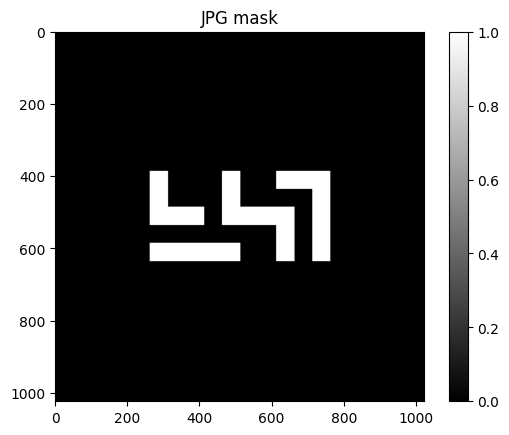

In [44]:
from PIL import Image
#read jpg
img_file = "mask_pattern.jpg"
image_obj = Image.open(img_file)

#Convert to Grayscale
image_gray = image_obj.convert('L') 
raw_data = np.array(image_gray)

#thresholding
#jpg turn sharp edges into gray fuzz (values like 10, 240, etc.)
#We force everything: if > 128 it becomes 1.0, else 0.0
mask = np.zeros_like(raw_data, dtype=np.float32)
mask[raw_data > 128] = 1.0 

#Dimensions
img_h, img_w = mask.shape
print("Loaded Mask Size:",img_w,"x",img_h)

#simulationwindow
N_sim = 1024
final_mask = np.zeros((N_sim, N_sim), dtype=np.float32)

start_y = (N_sim - img_h) // 2
start_x = (N_sim - img_w) // 2

if img_h > N_sim or img_w > N_sim:
    print("Warning: Image is larger than simulation window!")
    N_sim = 2048 #next size if needed
    print("Increased grid size to ",N_sim)
else:
    final_mask[start_y:start_y+img_h, start_x:start_x+img_w] = mask

#Plot mask
plt.imshow(final_mask, cmap='gray')
plt.title("JPG mask")
plt.colorbar()
plt.show()

In [45]:
#physical parameters
wavelength = 193.0   # 193 nm
NA = 1.35            # NA
L_nm = N_sim * pixel_size_nm  # Total window size in nm

#Grid Setup
x = np.linspace(-L_nm/2, L_nm/2, N_sim)
y = np.linspace(-L_nm/2, L_nm/2, N_sim)
X, Y = np.meshgrid(x, y)
dx = pixel_size_nm #1.0 nm

#Pupil Function
fx = np.fft.fftfreq(N_sim, d=dx)
fy = np.fft.fftfreq(N_sim, d=dx)
FX, FY = np.meshgrid(fx, fy)

freq_radius = np.sqrt(FX**2 + FY**2)
f_cutoff = NA / wavelength

pupil = np.zeros_like(freq_radius)
pupil[freq_radius <= f_cutoff] = 1.0

#Fwd optical Propagation
print("Calculating Diffraction...")
mask_fft = np.fft.fft2(final_mask)
filtered_fft = mask_fft * pupil
field = np.fft.ifft2(filtered_fft)

#Intensity (Aerial image)
intensity = np.abs(field)**2
intensity /= intensity.max() #Normalize

print("Simulation Complete")

Calculating Diffraction...
Simulation Complete


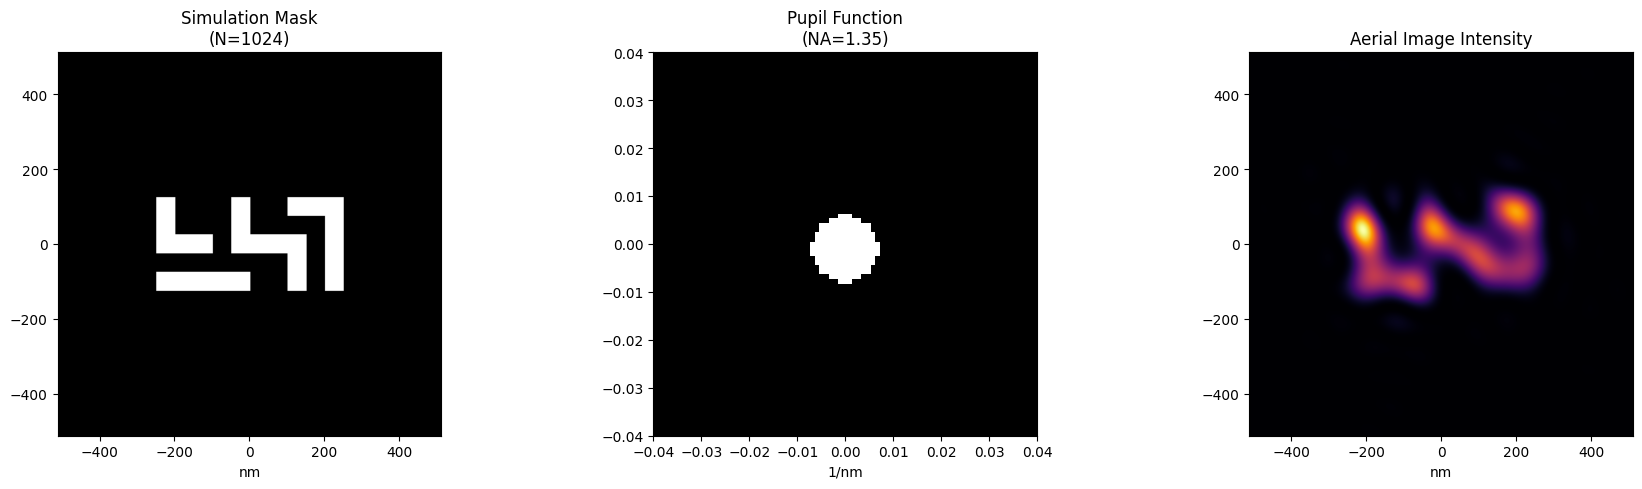

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1 Mask
ax[0].imshow(final_mask, cmap='gray',  extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2])
ax[0].set_title(f"Simulation Mask\n(N={N_sim})")
ax[0].set_xlabel("nm")

# 2 Pupil (Zoomed in)
# We limit the view because the frequency grid is huge
limit_freq = 0.04 # View range for pupil
ax[1].imshow(np.fft.fftshift(pupil), 
             extent=[np.min(fx), np.max(fx), np.min(fy), np.max(fy)], 
             cmap='gray')
ax[1].set_title(f"Pupil Function\n(NA={NA})")
ax[1].set_xlim([-limit_freq, limit_freq])
ax[1].set_ylim([-limit_freq, limit_freq])
ax[1].set_xlabel("1/nm")

# 3. Aerial Image
ax[2].imshow(intensity, cmap='inferno', extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2])
ax[2].set_title("Aerial Image Intensity")
ax[2].set_xlabel("nm")

plt.tight_layout()
plt.show()

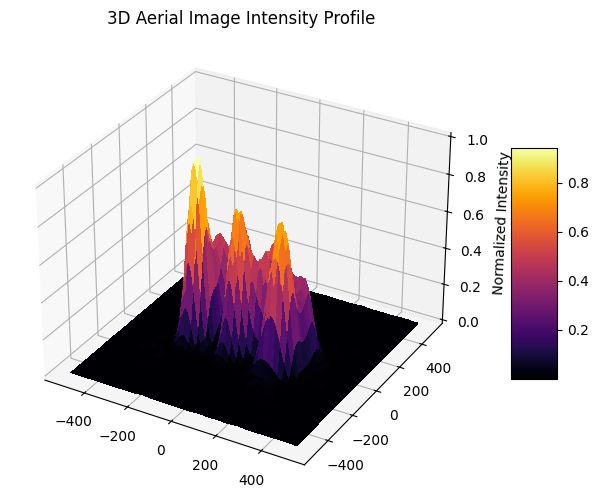

In [47]:
#3d aerial image
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, intensity, cmap="inferno", linewidth=0, antialiased=False)

ax.set_title("3D Aerial Image Intensity Profile")
ax.set_zlabel("Normalized Intensity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

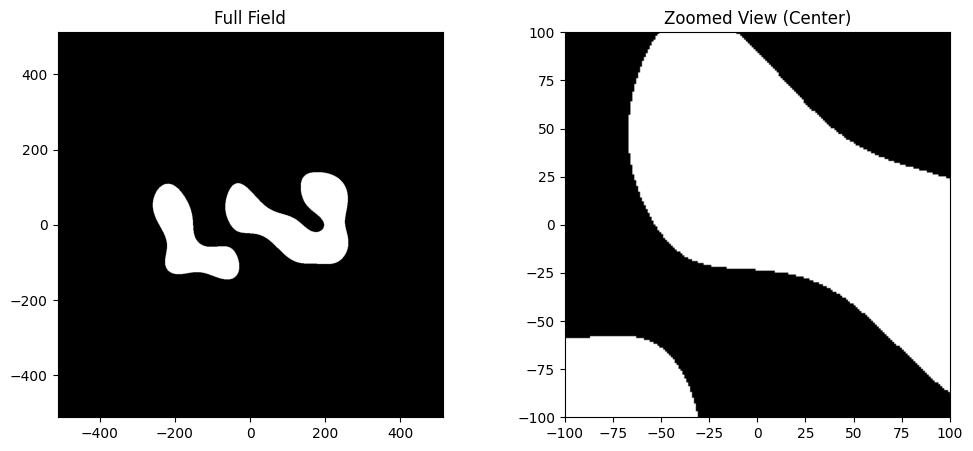

In [62]:
#resist image
resist_threshold = 0.25

resist_img = np.zeros_like(intensity)
resist_img[intensity >= resist_threshold] = 1.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(resist_img, cmap="gray", extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2])
ax1.set_title("Full Field")

ax2.imshow(resist_img, cmap="gray", extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2])
ax2.set_xlim([-100, 100])
ax2.set_ylim([-100, 100])
ax2.set_title("Zoomed View (Center)")

plt.show()